In [1]:
import pickle
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as multitest



In [8]:
path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
info.reset_index(drop=True, inplace=True)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])

info

,fn,target,dataset_name,sfreq,age,seconds
0,sedrykyn_sasha_7_og_concat_19.raw.fif,asd,asd,125,7,47.0
1,roma gritchin _5_fon_open_19.raw.fif,asd,asd,125,5,33.0
2,boy5_asd_og_new_19.raw.fif,asd,asd,125,5,50.0
3,viflyancev_4_asd_fon__concat_19.raw.fif,asd,asd,125,4,58.0
4,andrey_matveev3_asd_new_19.raw.fif,asd,asd,125,3,50.0
...,...,...,...,...,...,...
322,artem_sarkis_6_fon_19.raw.fif,typical,typical,125,6,44.0
323,gusarova_9_norm_19.raw.fif,typical,typical,125,9,83.0
324,акулов миша 10 от даши_ог_19.raw.fif,typical,typical,125,10,42.0
325,жавнис_3_19.raw.fif,typical,typical,125,3,386.0


In [9]:
bins = [2, 5, 7, 10]
info["age group"] = np.digitize(info["age"], bins)

In [27]:
def get_powers(signal, fmin=4, fmax=8, sfreq=125):
    epoch = signal[np.newaxis]
    freqs = np.linspace(fmin, fmax)
    return mne.time_frequency.tfr_array_multitaper(
        epoch,
        sfreq=sfreq,
        freqs=freqs,
        output='power',
        verbose=False
    )[0].mean(axis=1)

# def filters(age):
#     if age in range(2, 5):
#         return 4, 12
#     if age in range(5, 7):
#         return 5, 12
#     if age in range(7, 10):
#         return 6, 13
#     return 7, 13

def find_borders(arr):
    return np.where(np.pad(arr, (1, 0))[:-1] < arr), np.where(arr > np.pad(arr, (0, 1))[1:])

def filter_index(index, times, n_seconds, threshold):
    mask = index > threshold
    index_vals = []
    for chan in mask:
        index_val = 0.
        start_ix, end_ix = find_borders(chan)
        for start, end in zip(times[start_ix], times[end_ix]):
            if end - start < .1:
                continue
            index_val += end - start
        index_vals.append(index_val / n_seconds)
    return np.array(index_vals)

In [28]:
def index_1(eeg, fmin, fmax):
    alpha_powers = get_powers(eeg, fmin=fmin, fmax=fmax)
    beta_powers = get_powers(eeg, fmin=13, fmax=30)
    return alpha_powers / beta_powers

def index_2(eeg, fmin, fmax):
    alpha_powers = get_powers(eeg, fmin=fmin, fmax=fmax)
    beta_power = mne.time_frequency.psd_array_welch(eeg, sfreq=125, fmin=13, fmax=30, verbose=False)[0].mean(axis=1)
    return alpha_powers / beta_power[:, None]

In [29]:
beta_powers = [get_powers(eeg[:][0], fmin=13, fmax=30) for eeg in tqdm(eegs.values())]
mean_beta = [mne.time_frequency.psd_array_welch(
                eeg[:][0],
                sfreq=125,
                fmin=13,
                fmax=30,
                verbose=False
            )[0].mean(axis=1) for eeg in tqdm(eegs.values())]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [30]:
alpha_powers = {}
alpha_powers["2-6"] = [get_powers(eeg[:][0], 2, 6) for eeg in tqdm(eegs.values())]
alpha_powers["4-8"] = [get_powers(eeg[:][0], 4, 8) for eeg in tqdm(eegs.values())]
alpha_powers["8-13"] = [get_powers(eeg[:][0], 8, 13) for eeg in tqdm(eegs.values())]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [31]:
import pickle

with open("powers.pickle", "wb") as file:
    pickle.dump(dict(
        beta_powers=beta_powers,
        mean_beta=mean_beta,
        alpha_powers=alpha_powers
    ), file)

In [ ]:
with open("powers.pickle", "rb") as file:
    locals().update(pickle.load(file))

In [32]:
indices_raw_1 = {}
for kind, alpha_power in alpha_powers.items():
    indices_raw_1[kind] = [a / b for a, b in zip(alpha_power, beta_powers)]


In [34]:
indices_raw_2 = {}
for kind, alpha_power in alpha_powers.items():
    indices_raw_2[kind] = [a / m_b[:, None] for a, m_b in zip(alpha_power, mean_beta)]


In [35]:
all_index_1 = pd.concat(
{kind: pd.DataFrame([
        filter_index(idx, eeg.times, seconds, 5)
        for idx, eeg, seconds in zip(indices, eegs.values(), info.seconds.values)
    ], index=info["fn"], columns=ch_names)
    for kind, indices in indices_raw_1.items()
})

all_index_1 = all_index_1.join(info.set_index("fn")[["age group", "target"]])
all_index_1.index.set_names("kind", level=0, inplace=True)
all_index_1.fillna(0., inplace=True)


In [36]:
all_index_1[all_index_1["age group"] != 0].groupby(["age group", "kind", "target"]).mean()

Fp1       Fp2        F7        F3        Fz  \
age group kind target                                                      
1         2-6  asd      0.918409  0.914731  0.905623  0.924319  0.937907   
               typical  0.754702  0.770513  0.722062  0.779667  0.819280   
          4-8  asd      0.724119  0.736267  0.678326  0.744087  0.793159   
               typical  0.522140  0.541311  0.486402  0.593239  0.629228   
          8-13 asd      0.190843  0.208152  0.173507  0.244965  0.243019   
               typical  0.163849  0.180288  0.125132  0.213380  0.236879   
2         2-6  asd      0.884131  0.883057  0.839436  0.894816  0.908315   
               typical  0.816038  0.829901  0.777693  0.867209  0.876085   
          4-8  asd      0.671790  0.669860  0.616900  0.695304  0.735257   
               typical  0.570692  0.585195  0.487293  0.651585  0.678287   
          8-13 asd      0.216652  0.186045  0.211531  0.257176  0.261693   
               typical  0.150393  0.168056  0.115787  0.220276  0.222984   
3         2-6  asd      0.763937  0.780029  0.782398  0.807970  0.800898   
               typical  0.795899  0.776963  0.765728  0.821363  0.841693   
          4-8  asd      0.569266  0.554026  0.550373  0.619520  0.632988   
               typical  0.555907  0.527726  0.507863  0.626008  0.659455   
          8-13 asd      0.175946  0.177444  0.153040  0.209019  0.225732   
               typical  0.175147  0.174154  0.171701  0.235507  0.239573   
4         2-6  asd      0.640353  0.642118  0.625215  0.660360  0.647984   
               typical  0.696888  0.669350  0.653624  0.680247  0.718417   
          4-8  asd      0.458118  0.431826  0.411383  0.483920  0.484345   
               typical  0.445684  0.438015  0.377830  0.451055  0.525542   
          8-13 asd      0.137191  0.119165  0.099991  0.145751  0.160372   
               typical  0.155962  0.170625  0.122106  0.155043  0.204120   

                              F4        F8        T3        C3        Cz  \
age group kind target                                                      
1         2-6  asd      0.920520  0.873138  0.833812  0.934272  0.931626   
               typical  0.773561  0.747734  0.721986  0.812900  0.833115   
          4-8  asd      0.757717  0.646763  0.603350  0.784181  0.812835   
               typical  0.599619  0.536473  0.489206  0.636426  0.660491   
          8-13 asd      0.248033  0.192087  0.131437  0.267308  0.310139   
               typical  0.239742  0.172180  0.165117  0.313340  0.336900   
2         2-6  asd      0.885609  0.859190  0.841629  0.883128  0.899471   
               typical  0.839226  0.793501  0.754033  0.846780  0.855669   
          4-8  asd      0.668264  0.608635  0.604591  0.691163  0.735637   
               typical  0.614387  0.508918  0.479570  0.631899  0.656382   
          8-13 asd      0.210392  0.181570  0.212807  0.322983  0.308145   
               typical  0.221075  0.122830  0.128782  0.235160  0.296130   
3         2-6  asd      0.782596  0.760253  0.768835  0.813799  0.836026   
               typical  0.811560  0.748764  0.748998  0.824101  0.853567   
          4-8  asd      0.584504  0.507729  0.536167  0.643282  0.697106   
               typical  0.572816  0.465752  0.475517  0.652197  0.702441   
          8-13 asd      0.202695  0.148656  0.162442  0.291189  0.314769   
               typical  0.212121  0.146476  0.193082  0.326441  0.377846   
4         2-6  asd      0.637245  0.619752  0.576289  0.631028  0.647788   
               typical  0.658564  0.650916  0.579376  0.643818  0.679746   
          4-8  asd      0.441814  0.408305  0.342902  0.456725  0.486328   
               typical  0.439935  0.388971  0.335205  0.434396  0.497342   
          8-13 asd      0.132461  0.099365  0.083133  0.169990  0.222119   
               typical  0.164398  0.130716  0.149225  0.244875  0.257433   

                              C4        T4        T5        P3        Pz  \

In [37]:
all_index_2 = pd.concat(
{kind: pd.DataFrame([
        filter_index(idx, eeg.times, seconds, 770) 
        for idx, eeg, seconds in zip(indices, eegs.values(), info.seconds.values)
    ], index=info["fn"], columns=ch_names)
    for kind, indices in indices_raw_2.items()
})

all_index_2 = all_index_2.join(info.set_index("fn")[["age group", "target"]])
all_index_2.index.set_names("kind", level=0, inplace=True)
all_index_2.fillna(0., inplace=True)

In [38]:
all_index_2[all_index_2["age group"] != 0].groupby(["age group", "kind", "target"]).mean()

Fp1       Fp2        F7        F3        Fz  \
age group kind target                                                      
1         2-6  asd      0.874944  0.880819  0.851589  0.903790  0.915577   
               typical  0.643284  0.656990  0.566630  0.672744  0.724830   
          4-8  asd      0.582714  0.610837  0.529190  0.631913  0.707167   
               typical  0.365371  0.378026  0.314637  0.476724  0.514995   
          8-13 asd      0.083209  0.105319  0.075202  0.146269  0.132030   
               typical  0.083029  0.100149  0.059241  0.139978  0.158339   
2         2-6  asd      0.875999  0.873897  0.810235  0.909826  0.919548   
               typical  0.695637  0.726881  0.652126  0.799734  0.800571   
          4-8  asd      0.557719  0.541766  0.502338  0.615939  0.662092   
               typical  0.409736  0.437407  0.306616  0.536280  0.566207   
          8-13 asd      0.125926  0.094987  0.136077  0.157448  0.171571   
               typical  0.073073  0.098405  0.040824  0.127670  0.149089   
3         2-6  asd      0.742819  0.746582  0.760543  0.817865  0.812706   
               typical  0.675936  0.659465  0.649414  0.742281  0.759657   
          4-8  asd      0.463812  0.434958  0.427631  0.530294  0.560095   
               typical  0.391721  0.356724  0.350777  0.490187  0.531000   
          8-13 asd      0.097862  0.104645  0.078570  0.123744  0.146612   
               typical  0.092753  0.091307  0.097234  0.143599  0.141775   
4         2-6  asd      0.487564  0.487927  0.468225  0.557457  0.531707   
               typical  0.564996  0.540627  0.505307  0.549779  0.607466   
          4-8  asd      0.296421  0.259076  0.215427  0.351011  0.370884   
               typical  0.291462  0.291651  0.220536  0.306277  0.403822   
          8-13 asd      0.062779  0.056286  0.042000  0.076570  0.091875   
               typical  0.087396  0.104389  0.059690  0.083031  0.122492   

                              F4        F8        T3        C3        Cz  \
age group kind target                                                      
1         2-6  asd      0.898298  0.811235  0.740249  0.910619  0.915023   
               typical  0.680764  0.624323  0.576714  0.735718  0.752293   
          4-8  asd      0.650129  0.494069  0.419122  0.697815  0.722295   
               typical  0.470963  0.361342  0.336162  0.536088  0.581309   
          8-13 asd      0.131237  0.095392  0.061660  0.166438  0.196093   
               typical  0.152902  0.084371  0.096562  0.245370  0.257914   
2         2-6  asd      0.876622  0.842458  0.801933  0.896084  0.894012   
               typical  0.752271  0.692570  0.614540  0.778084  0.774283   
          4-8  asd      0.549360  0.451791  0.437293  0.618940  0.654610   
               typical  0.499023  0.342739  0.301199  0.511888  0.554650   
          8-13 asd      0.115790  0.101462  0.127952  0.236386  0.214079   
               typical  0.146539  0.056024  0.056050  0.153709  0.234123   
3         2-6  asd      0.788382  0.732969  0.725511  0.825508  0.862622   
               typical  0.727671  0.594013  0.617635  0.758671  0.785875   
          4-8  asd      0.485273  0.372167  0.393951  0.566081  0.641373   
               typical  0.428920  0.264358  0.336536  0.549466  0.612959   
          8-13 asd      0.120214  0.081872  0.088749  0.191159  0.227884   
               typical  0.124511  0.070126  0.130910  0.238617  0.290200   
4         2-6  asd      0.484601  0.474940  0.412035  0.519651  0.550746   
               typical  0.527801  0.516243  0.421598  0.533057  0.584534   
          4-8  asd      0.284140  0.243131  0.172825  0.321929  0.366093   
               typical  0.293001  0.247805  0.189781  0.312787  0.379488   
          8-13 asd      0.057901  0.044325  0.040260  0.097620  0.156072   
               typical  0.101979  0.068584  0.091898  0.168136  0.178940   

                              C4        T4        T5        P3        Pz  \

In [39]:
index_samples_1 = all_index_1[all_index_1["age group"] != 0].groupby(["age group", "kind", "target"]).agg(list)
index_samples_2 = all_index_2[all_index_2["age group"] != 0].groupby(["age group", "kind", "target"]).agg(list)

In [41]:
def compute_mw_col(col):
    stat, p = mannwhitneyu(*col)
    return {"W": stat, "p": p}

def compute_mw_df(df):
    return pd.DataFrame(df.apply(compute_mw_col).to_dict())

In [42]:
pd.DataFrame(index_samples_1.loc[1, "2-6"].apply(compute_mw_col).to_dict())

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
W,1239.000000,1169.500000,1256.000000,1141.000000,1030.500000,1119.50000,1105.000000,1056.000000,1170.500000,1091.500000,1082.000000,1130.000000,1021.000000,1089.000000,1020.500000,1012.500000,1036.000000,1114.000000,1057.500000
p,0.000155,0.001715,0.000081,0.004103,0.065706,0.00759,0.011257,0.037708,0.001661,0.016003,0.020325,0.005647,0.079796,0.017055,0.080599,0.094392,0.058538,0.008832,0.036438


In [45]:
p_values_1 = index_samples_1.groupby(["age group", "kind"]).apply(lambda y: y.apply(lambda x: mannwhitneyu(*x)[1]))
p_values_1_bonferroni = p_values_1 * p_values_1.shape[1]
p_values_1_fdr = p_values_1.apply(lambda row: multitest.fdrcorrection(row)[1])

p_values_2 = index_samples_2.groupby(["age group", "kind"]).apply(lambda y: y.apply(lambda x: mannwhitneyu(*x)[1]))
p_values_2_bonferroni = p_values_2 * p_values_2.shape[1]
p_values_2_fdr = p_values_2.apply(lambda row: multitest.fdrcorrection(row)[1])

Fp1        Fp2         F7         F3         Fz  \
age group kind                                                          
1         2-6    0.006931   0.011305   0.000817   0.039974   0.260469   
          4-8    0.017260   0.007573   0.024790   0.324027   0.257112   
          8-13   7.484926   2.709844   7.871923  19.000000  16.745407   
2         2-6    0.001450   0.017281   0.002966   0.087153   0.033357   
          4-8    0.158851   0.858099   0.065103   3.061555   1.677498   
          8-13  11.461413  10.043344   0.930522  13.877780   5.642621   
3         2-6    2.382199   2.185230   0.569757   9.816087   9.376285   
          4-8    3.793076   2.629183   3.557097   8.447051  12.761058   
          8-13  13.059592  16.532674  12.397729  13.675314  15.035603   
4         2-6    6.700415   8.200644  11.244191  14.515230   8.685667   
          4-8   12.493722   8.042130  10.232756  12.690830  11.338564   
          8-13   6.337460   1.089225   9.669779  19.000000   4.149072   

                       F4         F8         T3         C3         Cz  \
age group kind                                                          
1         2-6    0.174803   0.234624   0.646175   0.079117   0.194734   
          4-8    0.160990   0.766787   1.530313   0.307980   1.184931   
          8-13  12.880264  12.832899   7.386572   6.843401   7.188060   
2         2-6    0.165431   0.029415   0.008660   0.075406   0.695033   
          4-8    7.707324   0.987306   0.354495   1.645164   3.859869   
          8-13   1.734444  12.434819   1.814599   3.060720   5.403509   
3         2-6    5.294709   0.047192   1.722276   7.344075  10.587532   
          4-8    5.542911   0.694765   4.014273  13.573849  12.560856   
          8-13   9.546524  14.331909  17.461278   2.278231   1.159568   
4         2-6    9.357439   9.528717  15.561008  15.985406  10.964536   
          4-8   12.888093  13.087622  14.099810  18.783193  12.789438   
          8-13   2.444153   0.961472   1.749310   4.458680   4.740984   

                       C4         T4         T5         P3         Pz  \
age group kind                                                          
1         2-6    0.452910   0.138324   1.955921   0.498769   0.244051   
          4-8    1.184904   1.383006   9.207673   0.395846   0.395846   
          8-13   5.150612   5.325841  17.563616   4.983509   9.410277   
2         2-6    0.053645   0.367847   0.515175   0.945990   0.012599   
          4-8    6.270641   3.386751   2.618159   1.217804   0.022791   
          8-13  13.033557  11.697946   2.072293  13.350019   6.987702   
3         2-6    5.542911   0.123673  16.214640   2.249388   0.369428   
          4-8    8.862773   3.420275  10.039673   5.294709   0.933700   
          8-13   1.217152   7.475006   4.419942  16.537477  18.560533   
4         2-6   15.350805   9.966260  10.054091  14.618657  13.897919   
          4-8   14.411427  10.409863   8.845909  18.241553  15.985406   
          8-13   2.670655   0.160526  13.872235   3.714057  12.787763   

                       P4         T6         O1         O2  
age group kind                                              
1         2-6    2.170256   1.248349   0.170036   1.065782  
          4-8   16.190948   6.316216   0.400296   3.161975  
          8-13   0.710793  11.390735  16.300313   5.202499  
2         2-6    0.065115   0.279381   0.279381   0.065103  
          4-8    0.794628   3.330118   0.152493   0.038943  
          8-13  14.538422  16.700569   0.309944   4.165732  
3         2-6    4.513375   6.437496  11.627753   6.472318  
          4-8    3.915162  16.539162  15.142415  14.456458  
          8-13  12.505281   5.961218   1.965705   0.593321  
4         2-6   15.985304   6.559981  17.268966   5.144984  
          4-8   15.035689   6.144024   7.800040   1.684105  
          8-13   7.877590  12.970314   4.192001   2.973567

In [46]:
age_groups = ["2-4", "5-6", "7-9", "10+"]
freqs = ["2-6 Hz", "4-8 Hz", "8-13 Hz"]

In [47]:
montage = mne.channels.make_standard_montage('standard_1020')

mne_info = mne.io.meas_info.create_info(montage.ch_names, sfreq=128, ch_types="eeg")
mne.io.RawArray(np.zeros((len(montage.ch_names), 1)), mne_info, copy=None).set_montage(montage)
channels_to_use_ = [ch for ch in mne_info.ch_names if ch in ch_names]
mne_info.pick_channels(channels_to_use_)
_, pos, _, ch_names, _, _, _ = mne.viz.topomap._prepare_topomap_plot(mne_info, 'eeg')
pos = pd.DataFrame(pos, columns=['x', 'y'], index=ch_names)

Creating RawArray with float64 data, n_channels=94, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [48]:
from matplotlib import colors
import matplotlib.cm

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(matplotlib.cm.gray, minval=.6, maxval=1.)


In [49]:
def get_significant(p_values, alpha=.05):
    return (p_values < alpha).T.apply(lambda x: list(x[x].index))

In [52]:
def plot_topomap(values, ax, highlight):
    mne.viz.utils.plot_sensors(mne_info, show_names=True, axes=ax, show=False)
    ax.scatter(*pos.loc[highlight].values.T, color="red")
    return mne.viz.plot_topomap(values[pos.index], pos.values,
                                axes=ax, show=False, vmin=0., vmax=1., cmap=cmap)

In [75]:
def plot_p_values(p_values, title=None):
    fig, axes = plt.subplots(3, 4, figsize=(18, 10))
    fig.suptitle(title)

    significant = get_significant(p_values)

    for (key, val), ax in zip(p_values.iterrows(), axes.T.ravel()):
        im, _ = plot_topomap(val, ax, significant[key])

    for ax, ag_name in zip(axes[0], age_groups):
        ax.set_title(ag_name, fontsize=24)

    for ax, freq in zip(axes.T[0],freqs):
        ax.text(-.15, 0., freq, size=24,
                verticalalignment='center', rotation=90)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.8])
    fig.colorbar(im, cax=cbar_ax).set_label("p-value", size=24)
    return fig

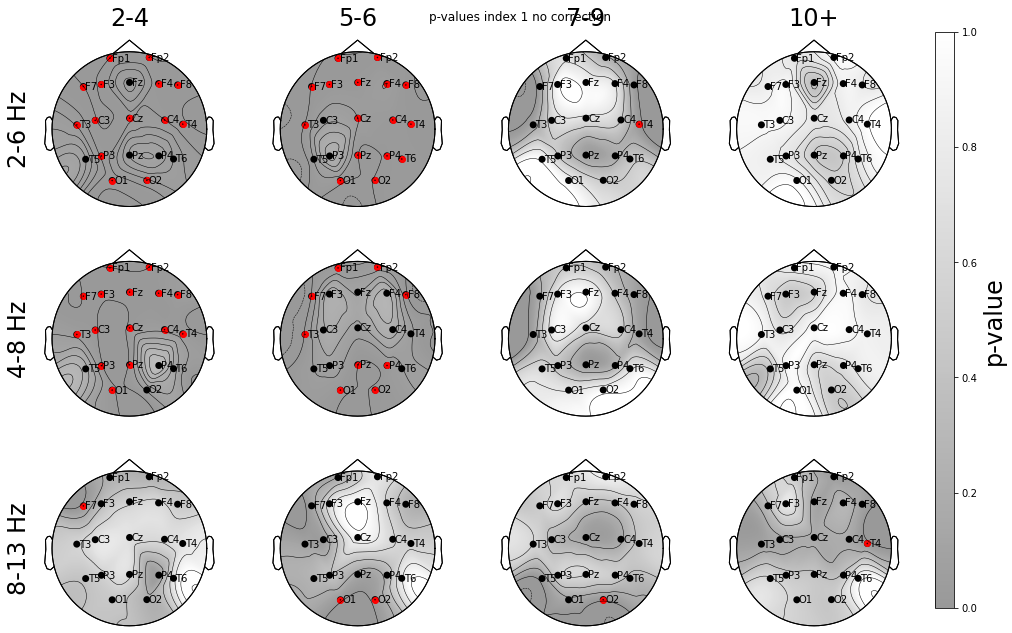

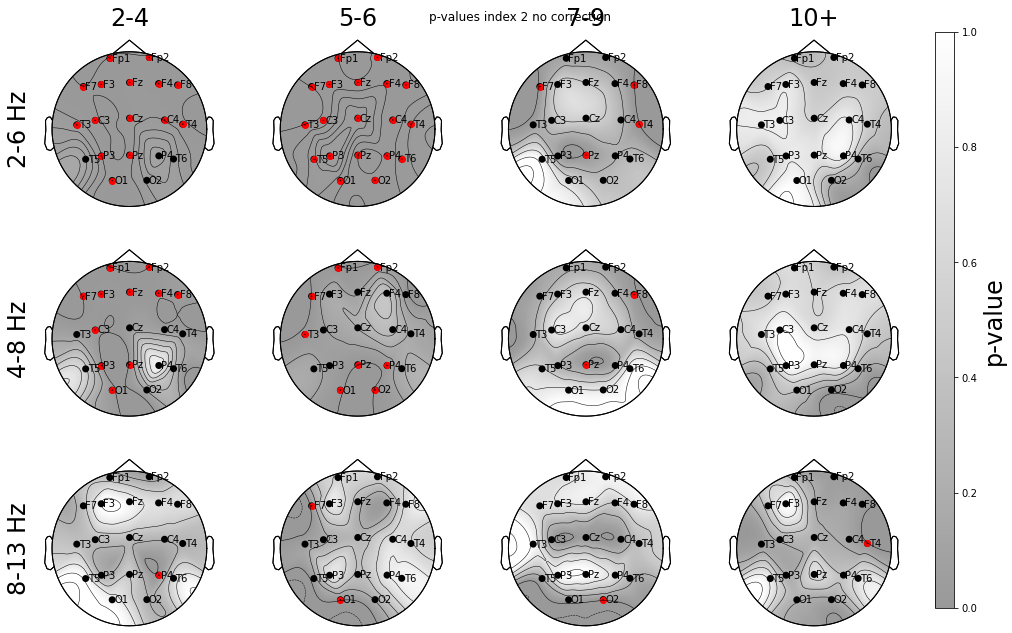

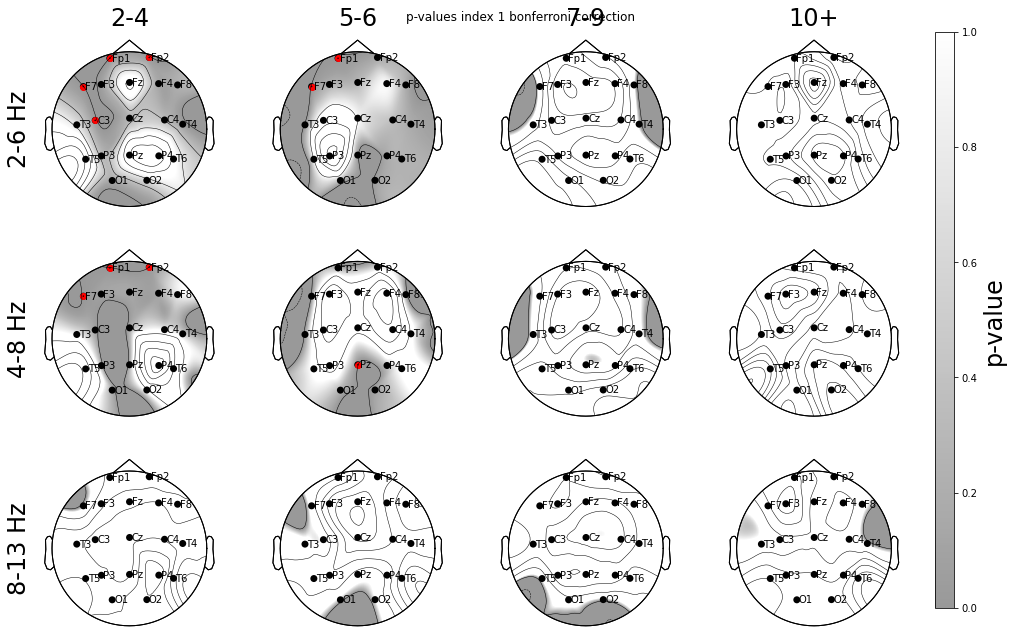

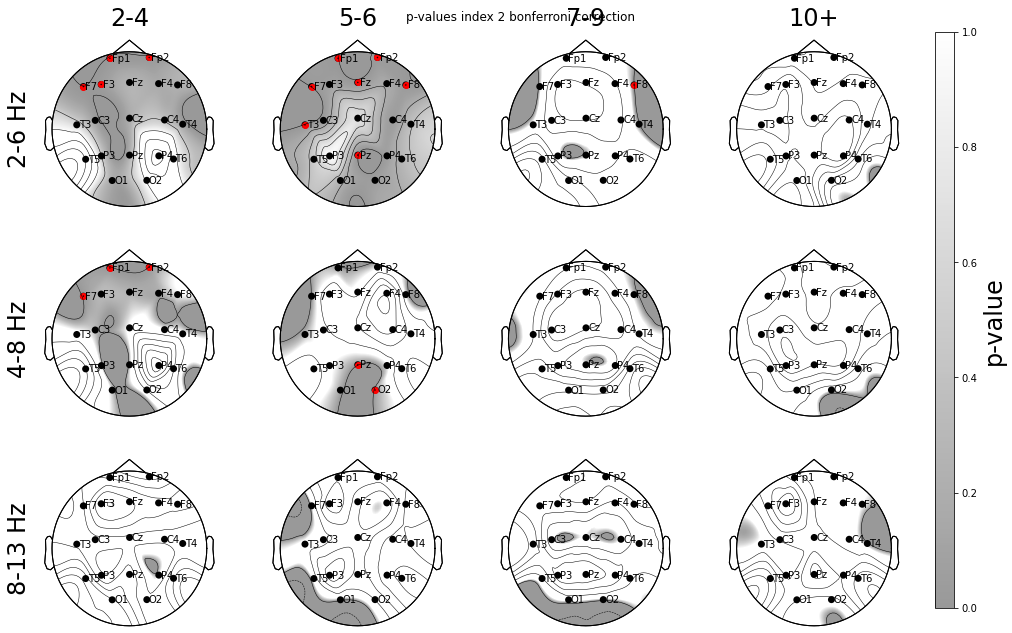

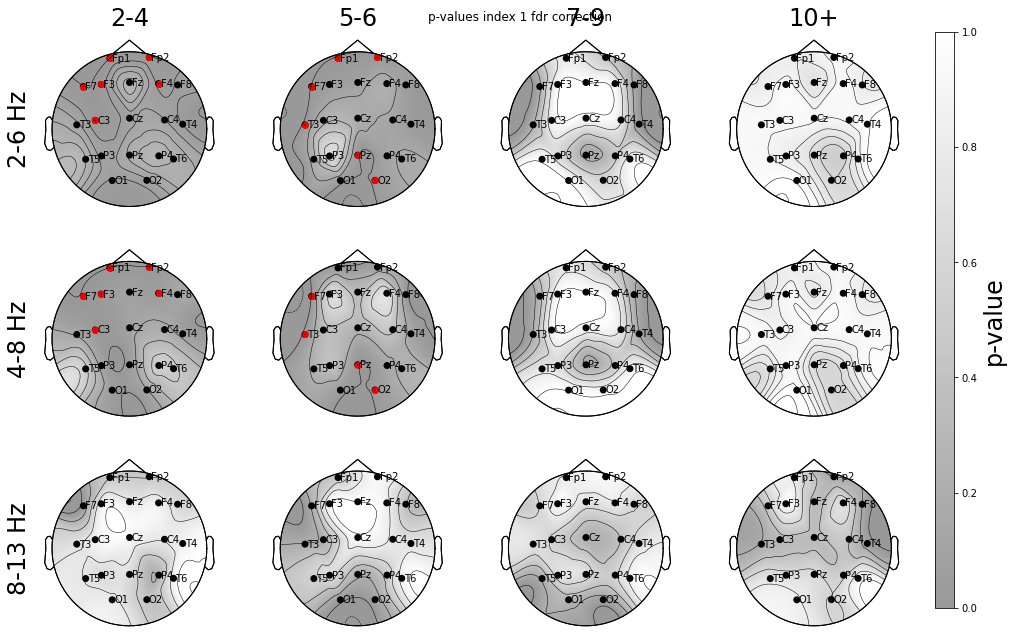

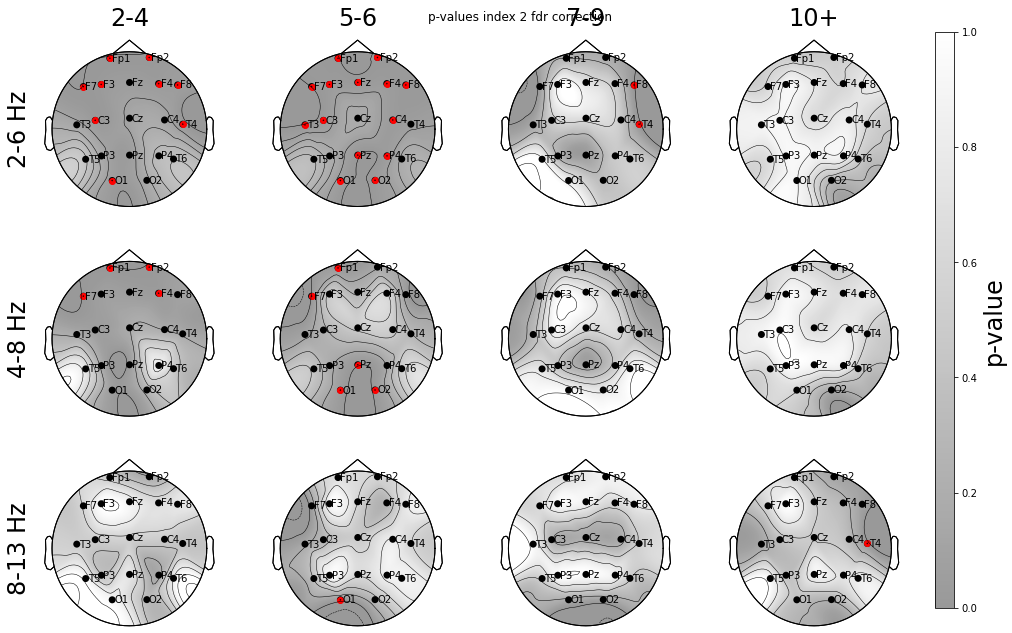

In [76]:
plot_p_values(p_values_1, "p-values index 1 no correction")
plt.show()
plot_p_values(p_values_2, "p-values index 2 no correction")
plt.show()
plot_p_values(p_values_1_bonferroni, "p-values index 1 bonferroni correction")
plt.show()
plot_p_values(p_values_2_bonferroni, "p-values index 2 bonferroni correction")
plt.show()
plot_p_values(p_values_1_fdr, "p-values index 1 fdr correction")
plt.show()
plot_p_values(p_values_2_fdr, "p-values index 2 fdr correction")
plt.show()